In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.plot import heatmap
from graspy.simulations import er_np, sbm
from graspy.utils import symmetrize
from joblib import Parallel, delayed
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu, truncnorm

warnings.filterwarnings("ignore")
%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
def generate_pop(m, var_1, var_2, block_1=5, block_2=15):
    pop_1 = []
    pop_2 = []

    for _ in range(m):
        seeds = np.random.randint(0, 2147483647, size=8)

        n = [block_1, block_2]
        p = [[1, 1], [1, 1]]
        sd_1 = np.sqrt(var_1)
        sd_2 = np.sqrt(var_2)

        wt_func = [[truncnorm.rvs, truncnorm.rvs], [truncnorm.rvs, truncnorm.rvs]]

        wt_args_1 = [
            [
                dict(a=-1 / sd_1, b=1 / sd_1, scale=sd_1, random_state=seeds[0],),
                dict(a=-1 / sd_1, b=1 / sd_1, scale=sd_1, random_state=seeds[1],),
            ],
            [
                dict(a=-1 / sd_1, b=1 / sd_1, scale=sd_1, random_state=seeds[2],),
                dict(a=-1 / sd_1, b=1 / sd_1, scale=sd_1, random_state=seeds[3],),
            ],
        ]

        wt_args_2 = [
            [
                dict(a=-1 / sd_2, b=1 / sd_2, scale=sd_2, random_state=seeds[4],),
                dict(a=-1 / sd_2, b=1 / sd_2, scale=sd_2, random_state=seeds[5],),
            ],
            [
                dict(a=-1 / sd_2, b=1 / sd_2, scale=sd_2, random_state=seeds[6],),
                dict(a=-1 / sd_2, b=1 / sd_2, scale=sd_2, random_state=seeds[7],),
            ],
        ]

        pop_1.append(
            symmetrize(sbm(n, p, directed=True, wt=wt_func, wtargs=wt_args_1), "triu")
        )
        pop_2.append(
            symmetrize(sbm(n, p, directed=True, wt=wt_func, wtargs=wt_args_2), "triu")
        )

    return np.array(pop_1), np.array(pop_2)


def compute_statistic(test, pop1, pop2):
    if test.__name__ == "ttest_ind":
        test_statistics, _ = ttest_ind(pop1, pop2, axis=0)
        np.nan_to_num(test_statistics, copy=False)
    else:
        n = pop1.shape[-1]
        test_statistics = np.zeros((n, n))

        for i in range(n):
            for j in range(i, n):
                x_ij = pop1[:, i, j]
                y_ij = pop2[:, i, j]

                if np.array_equal(x_ij, y_ij):
                    test_statistics[i, j] = 0
                else:
                    tmp, pval = test(x_ij, y_ij)
                    test_statistics[i, j] = pval

        test_statistics = symmetrize(test_statistics, method="triu")

    return test_statistics


def compute_pr_at_k(different_n, k, test_statistics, test):
    n = test_statistics.shape[0]
    labels = np.zeros((n, n))
    labels[0:different_n, 0:different_n] = 1

    triu_idx = np.triu_indices_from(test_statistics, k=1)
    test_statistics_ = np.abs(test_statistics[triu_idx])
    labels_ = labels[triu_idx]

    if test.__name__ == "ttest_ind":
        idx = np.argsort(test_statistics_)[::-1]
    else:
        idx = np.argsort(test_statistics_)
    sorted_labels = labels_[idx]

    precision_at_k = sorted_labels[:k].mean()
    recall_at_k = sorted_labels[:k].sum() / sorted_labels.sum()

    return precision_at_k, recall_at_k


def compute_trustworthiness(pvals):
    idx = np.triu_indices(pvals.shape[0], k=1)
    res = pvals[idx]

    fraction_correct = (res <= 0.05).mean()
    all_correct = np.all(res <= 0.05)

    return fraction_correct, all_correct

<IPython.core.display.Javascript object>

In [5]:
def run_experiment(m, var_1, var_2, reps):
    tests = ttest_ind, wilcoxon, mannwhitneyu

    precisions = []
    recalls = []

    for i in range(reps):
        tmp_precisions = []
        tmp_recalls = []
        pop1, pop2 = generate_pop(m=m, var_1=var_1, var_2=var_2)

        for test in tests:
            test_statistics = compute_statistic(test, pop1, pop2)

            for k in range(1, 11):
                precision, recall = compute_pr_at_k(5, k, test_statistics, test)
                tmp_precisions.append(precision)
                tmp_recalls.append(recall)

        precisions.append(tmp_precisions)
        recalls.append(tmp_recalls)

    precisions = np.array(precisions).mean(axis=0)
    recalls = np.array(recalls).mean(axis=0)

    to_append = [var_1, var_2, m, *precisions, *recalls]

    return to_append

<IPython.core.display.Javascript object>

In [6]:
spacing = 50
delta = 0.05

var_1s = np.linspace(0, 3, spacing + 1)[1:]
var_2s = np.ones(spacing)
ms = np.linspace(0, 500, spacing + 1).astype(int)[1:]
reps = 100

<IPython.core.display.Javascript object>

In [7]:
args = [
    (m, var_1, var_2, reps) for m, (var_1, var_2) in product(ms, zip(var_1s, var_2s))
]

res = Parallel(n_jobs=-3, verbose=1)(delayed(run_experiment)(*arg) for arg in args)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-3)]: Done 262 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-3)]: Done 612 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-3)]: Done 1062 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-3)]: Done 1612 tasks      | elapsed: 83.9min
[Parallel(n_jobs=-3)]: Done 2262 tasks      | elapsed: 159.5min
[Parallel(n_jobs=-3)]: Done 2500 out of 2500 | elapsed: 188.4min finished


<IPython.core.display.Javascript object>

In [8]:
cols = [
    "var1",
    "var2",
    "m",
    *[
        f"{test.__name__}_precision_at_{k}"
        for test in [ttest_ind, wilcoxon, mannwhitneyu]
        for k in range(1, 11)
    ],
    *[
        f"{test.__name__}_recall_at_{k}"
        for test in [ttest_ind, wilcoxon, mannwhitneyu]
        for k in range(1, 11)
    ],
]
res_df = pd.DataFrame(res, columns=cols)

<IPython.core.display.Javascript object>

In [9]:
res_df.to_csv("20200127_precision_recall_results.csv", index=False)

<IPython.core.display.Javascript object>

# Figures

In [10]:
res_df = pd.read_csv("20200127_precision_recall_results.csv")

<IPython.core.display.Javascript object>

In [11]:
res_df

,var1,var2,m,ttest_ind_precision_at_1,ttest_ind_precision_at_2,ttest_ind_precision_at_3,ttest_ind_precision_at_4,ttest_ind_precision_at_5,ttest_ind_precision_at_6,ttest_ind_precision_at_7,...,mannwhitneyu_recall_at_1,mannwhitneyu_recall_at_2,mannwhitneyu_recall_at_3,mannwhitneyu_recall_at_4,mannwhitneyu_recall_at_5,mannwhitneyu_recall_at_6,mannwhitneyu_recall_at_7,mannwhitneyu_recall_at_8,mannwhitneyu_recall_at_9,mannwhitneyu_recall_at_10
0,0.06,1.0,10,0.07,0.065,0.066667,0.0625,0.060,0.060000,0.057143,...,0.011,0.015,0.018,0.023,0.028,0.036,0.045,0.051,0.058,0.063
1,0.12,1.0,10,0.02,0.050,0.053333,0.0525,0.054,0.058333,0.058571,...,0.005,0.010,0.013,0.022,0.030,0.036,0.042,0.046,0.051,0.055
2,0.18,1.0,10,0.08,0.080,0.063333,0.0575,0.056,0.053333,0.058571,...,0.006,0.014,0.020,0.023,0.027,0.030,0.034,0.038,0.045,0.051
3,0.24,1.0,10,0.03,0.050,0.040000,0.0375,0.042,0.048333,0.047143,...,0.008,0.011,0.012,0.012,0.014,0.018,0.024,0.034,0.044,0.051
4,0.30,1.0,10,0.04,0.060,0.056667,0.0600,0.060,0.056667,0.061429,...,0.005,0.012,0.020,0.026,0.030,0.037,0.040,0.044,0.051,0.054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2.76,1.0,500,0.03,0.025,0.026667,0.0400,0.040,0.036667,0.034286,...,0.003,0.004,0.007,0.015,0.018,0.022,0.026,0.031,0.035,0.040
2496,2.82,1.0,500,0.02,0.035,0.033333,0.0375,0.038,0.036667,0.038571,...,0.002,0.008,0.009,0.012,0.019,0.022,0.029,0.036,0.041,0.049
2497,2.88,1.0,500,0.03,0.055,0.070000,0.0650,0.064,0.068333,0.058571,...,0.003,0.013,0.019,0.026,0.035,0.041,0.042,0.046,0.052,0.061
2498,2.94,1.0,500,0.05,0.050,0.050000,0.0525,0.052,0.055000,0.054286,...,0.005,0.012,0.016,0.020,0.027,0.032,0.038,0.047,0.053,0.054


<IPython.core.display.Javascript object>

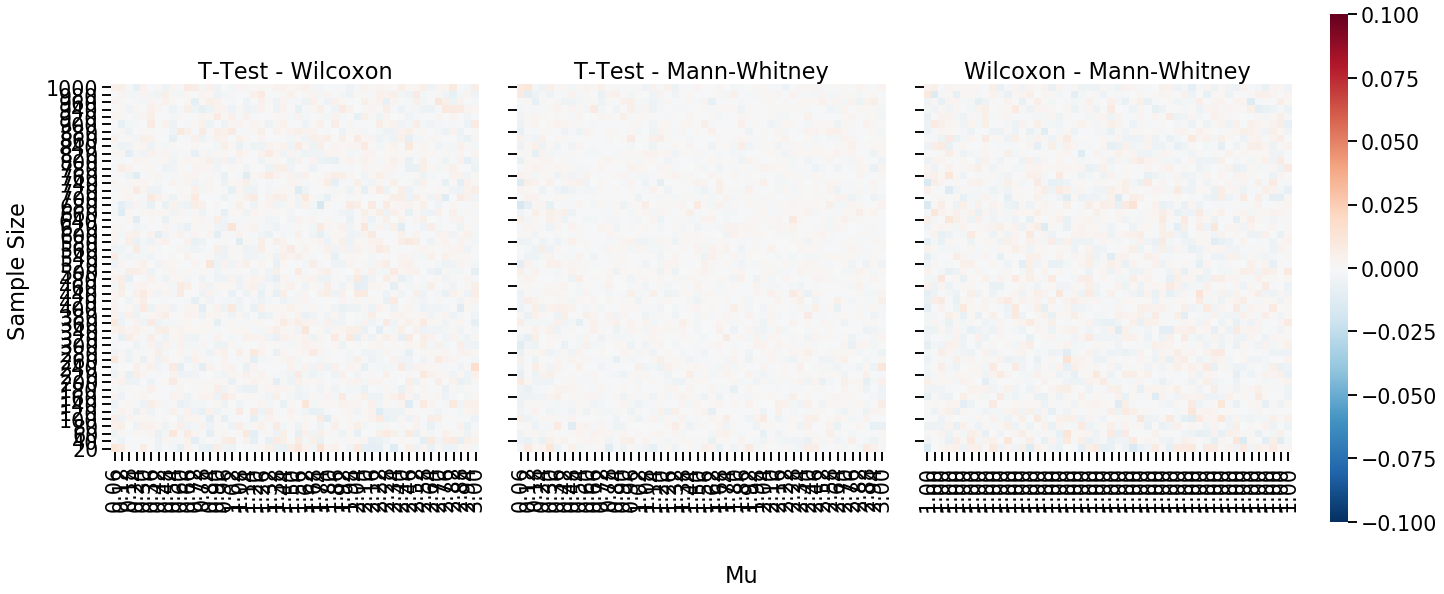

<IPython.core.display.Javascript object>

In [13]:
size = np.sqrt(res_df.shape[0]).astype(int)

ttest_prec = np.flipud(res_df.ttest_ind_precision_at_10.values.reshape(-1, spacing))
wilcoxon_prec = np.flipud(res_df.wilcoxon_precision_at_10.values.reshape(-1, spacing))
mannwhitney_prec = np.flipud(
    res_df.mannwhitneyu_precision_at_10.values.reshape(-1, spacing)
)

samples = np.linspace(0, 500, spacing + 1).astype(int)[1:] * 2
samples = [str(i) for i in samples]

vmin = -0.1
vmax = -vmin


fmt = lambda x: "{:.2f}".format(x)
with sns.plotting_context("talk", font_scale=1.25):
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(
        1, 4, gridspec_kw={"width_ratios": [1, 1, 1, 0.05]}, figsize=(20, 8)
    )

    sns.heatmap(
        ttest_prec - wilcoxon_prec,
        ax=ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in var_1s],
        yticklabels=[f"{int(m*2)}" for m in ms][::-1],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    # ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1]+1, 10))
    # ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0]+1, 10)[::-1])
    ax[0].set_title("T-Test - Wilcoxon")

    sns.heatmap(
        ttest_prec - mannwhitney_prec,
        ax=ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in var_1s],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    # ax[1].set_xticks(np.arange(0, ax[1].get_xlim()[1]+1, 10))
    # ax[1].set_yticks(np.arange(0, ax[1].get_ylim()[0]+1, 10)[::-1])
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].set_title("T-Test - Mann-Whitney")

    sns.heatmap(
        wilcoxon_prec - mannwhitney_prec,
        ax=ax[2],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in var_2s],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    # ax[2].set_xticks(np.arange(0, ax[1].get_xlim()[1]+1, 10))
    # ax[2].set_yticks(np.arange(0, ax[1].get_ylim()[0]+1, 10)[::-1])
    ax[2].yaxis.set_major_formatter(plt.NullFormatter())
    ax[2].set_title("Wilcoxon - Mann-Whitney")

    fig.text(-0.01, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.03, "Mu", va="center", ha="center")

    fig.tight_layout()

    # fig.savefig("./figures/20191209_precision_diff.png", dpi=300, bbox_inches='tight')
    # fig.savefig("./figures/20191209_precision_diff.pdf", dpi=300, bbox_inches='tight')

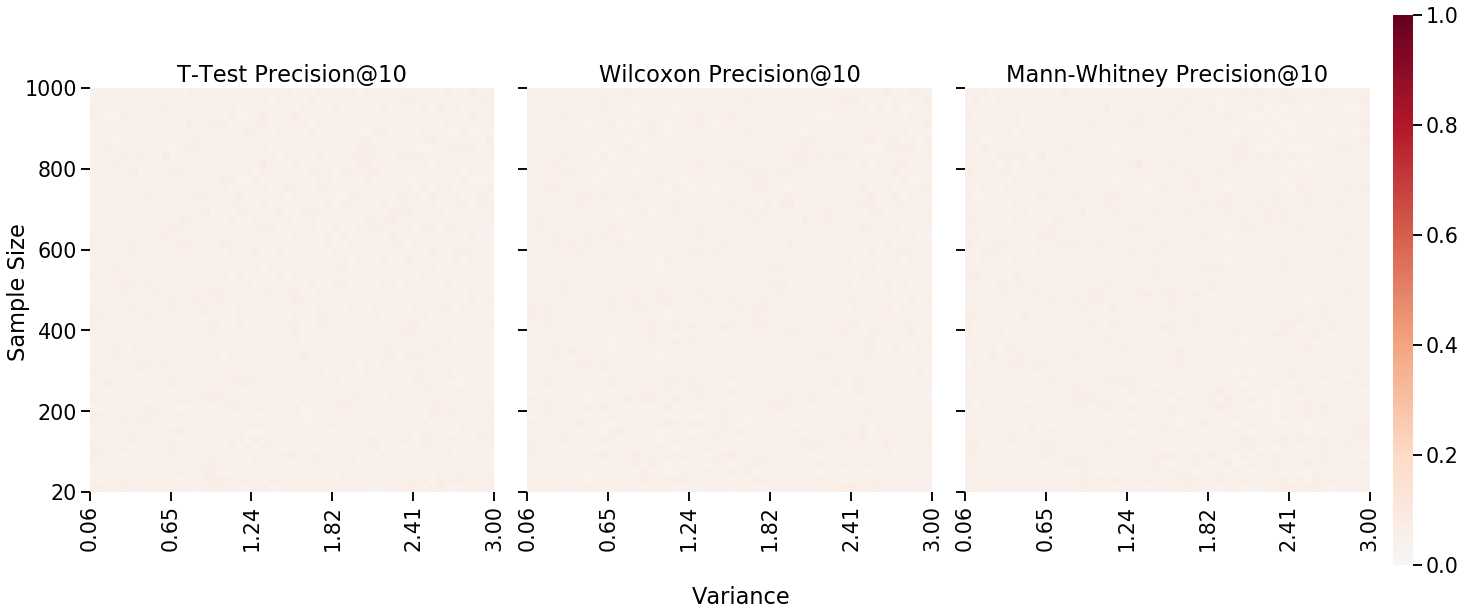

<IPython.core.display.Javascript object>

In [66]:
size = np.sqrt(res_df.shape[0]).astype(int)

ttest_prec = np.flipud(res_df.ttest_ind_precision_at_10.values.reshape(-1, spacing))
wilcoxon_prec = np.flipud(res_df.wilcoxon_precision_at_10.values.reshape(-1, spacing))
mannwhitney_prec = np.flipud(
    res_df.mannwhitneyu_precision_at_10.values.reshape(-1, spacing)
)

samples = np.linspace(0, 500, spacing + 1).astype(int) * 2
samples[0] += 20
samples = [str(i) for i in samples]

vmin = -0
vmax = 1


fmt = lambda x: "{:.2f}".format(x)
with sns.plotting_context("talk", font_scale=1.25):
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(
        1,
        4,
        gridspec_kw={"width_ratios": [1, 1, 1, 0.05]},
        figsize=(20, 8),
        constrained_layout=True,
    )

    sns.heatmap(
        ttest_prec,
        ax=ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in np.linspace(0.06, 3, spacing + 1)[::10]],
        yticklabels=samples[::-10],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1] + 1, 10))
    ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0] + 1, 10))
    ax[0].set_title("T-Test Precision@10")

    sns.heatmap(
        wilcoxon_prec,
        ax=ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in np.linspace(0.06, 3, spacing + 1)[::10]],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[1].set_xticks(np.arange(0, ax[1].get_xlim()[1] + 1, 10))
    ax[1].set_yticks(np.arange(0, ax[1].get_ylim()[0] + 1, 10)[::-1])
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].set_title("Wilcoxon Precision@10")

    sns.heatmap(
        mannwhitney_prec,
        ax=ax[2],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in np.linspace(0.06, 3, spacing + 1)[::10]],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[2].set_xticks(np.arange(0, ax[1].get_xlim()[1] + 1, 10))
    ax[2].set_yticks(np.arange(0, ax[1].get_ylim()[0] + 1, 10)[::-1])
    ax[2].yaxis.set_major_formatter(plt.NullFormatter())
    ax[2].set_title("Mann-Whitney Precision@10")

    fig.text(-0.01, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.03, "Variance", va="center", ha="center")

    fig.savefig("./figures/20200128_precision.png", dpi=300, bbox_inches="tight")
    fig.savefig("./figures/20200128_precision.pdf", dpi=300, bbox_inches="tight")